# **Clustering lynx**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from scipy.stats import norm
from safetensors import safe_open

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from oml.functional.metrics import calc_cmc, calc_map, calc_precision
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.transformations_and_augmentations import transforms
from lynx_id.data.collate import collate_single
from lynx_id.model.embeddings import EmbeddingModel
from lynx_id.model.clustering import ClusteringModel

plt.rcParams['figure.figsize'] = [20, 5]

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


In [4]:
random.seed(42)

## **Load data**

### Load our best model to get embeddings from image

In [5]:
embedding_model = EmbeddingModel(
    model_path="/gpfswork/rech/ads/uxp55sd/downloaded_model/model_best_0.512.pth",
    device=DEVICE
)

/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/torchvision-0.16.1+fdea156-py3.11-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/torchvision-0.16.1+fdea156-py3.11-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Load dataset

In [6]:
# load dataset
from lynx_id.data.dataset import LynxDataset
from pathlib import Path
from lynx_id.data.transformations_and_augmentations import transforms

lynxDataset = LynxDataset(dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/france/lynx_dataset_france.csv"), 
                      loader="pil",
                      transform=transforms,  # Define 'preprocess' earlier in your script
                      augmentation=None,
                      probabilities=[1, 0, 0],
                      mode='single',
                      device="auto")

In [7]:
print(f"{len(lynxDataset)}")

3081


In [8]:
train_lynxDataset, valid_lynxDataset, eval_lynxDataset = lynxDataset.split()

In [9]:
print(f"{len(train_lynxDataset)=} images")
print(f"{len(valid_lynxDataset)=} images")
print(f"{len(eval_lynxDataset)=} images")

len(train_lynxDataset)=2342 images
len(valid_lynxDataset)=280 images
len(eval_lynxDataset)=459 images


In [10]:
train_lynx_id_counts = train_lynxDataset.dataframe['lynx_id'].value_counts()
eval_lynx_id_counts = eval_lynxDataset.dataframe['lynx_id'].value_counts()


print(f"TRAIN | Number of individuals: {len(train_lynx_id_counts)}")
print(f"EVAL  | Number of individuals: {len(eval_lynx_id_counts)}")

TRAIN | Number of individuals: 255
EVAL  | Number of individuals: 267


In [11]:
set_individuals_train = set(train_lynx_id_counts.index)
set_individuals_eval = set(eval_lynx_id_counts.index)

print(f"The train and eval set share {len(set_individuals_train.intersection(set_individuals_eval))} individuals in common.")
print(f"Compared to the training set, the eval set has {len(set_individuals_eval - set_individuals_train)} new individuals.")

The train and eval set share 253 individuals in common.
Compared to the training set, the eval set has 14 new individuals.


In [12]:
new_lynx_id = set_individuals_eval - set_individuals_train

In [13]:
train_dataloader = DataLoader(
    train_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

eval_dataloader = DataLoader(
    eval_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

In [14]:
# Compute all embeddings
train_embeddings = embedding_model.compute_embeddings(
    train_dataloader, 
    # save_embeddings_path="/gpfswork/rech/ads/uxp55sd/DP-SCR_Identify-and-estimate-density-lynx-population/test_scripts/embeddings/embeddings.safetensors",
    # save_lynx_id_path="/gpfswork/rech/ads/uxp55sd/DP-SCR_Identify-and-estimate-density-lynx-population/test_scripts/embeddings/embeddings_lynx_ids.csv"
)

eval_embeddings = embedding_model.compute_embeddings(
    eval_dataloader, 
    # save_embeddings_path="",
    # save_lynx_id_path=""
)

100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


In [15]:
train_embeddings = train_embeddings.to("cpu")
eval_embeddings = eval_embeddings.to("cpu")

print(f"TRAIN | Number of images: {train_embeddings.shape[0]} | Embedding shape: {train_embeddings.shape[1]}")
print(f"EVAL  | Number of images: {eval_embeddings.shape[0]} | Embedding shape: {eval_embeddings.shape[1]}")

TRAIN | Number of images: 2342 | Embedding shape: 2048
EVAL  | Number of images: 459 | Embedding shape: 2048


In [16]:
# True lynx_id
eval_lynx_id = eval_lynxDataset.dataframe['lynx_id'].tolist()
train_lynx_id = train_lynxDataset.dataframe['lynx_id'].to_list()

# Update of true `lynx_id` data 
count_new = 0
for i, element in enumerate(tqdm(eval_lynx_id)):
    if element in new_lynx_id:
        eval_lynx_id[i] = "New"
        count_new += 1

print(f"{count_new=}")

100%|██████████| 459/459 [00:00<00:00, 2063435.73it/s]

count_new=14


In [17]:
# Check that we have new individuals
assert "New" in eval_lynx_id

## **KNN**

In [18]:
clustering_model = ClusteringModel(
    embeddings_knowledge=train_embeddings,
    lynx_ids_knowledge=train_lynx_id,
    n_neighbors=5,
    algorithm="brute",
    metric="minkowski"
)

In [33]:
# Nearest Neighbors
clustering_model.clustering(eval_embeddings)
indices = clustering_model.indices
distances = clustering_model.distances
indices.shape

(459, 5)

### Detecting new candidates

In this notebook, we use both a **simple threshold** defined manually and a method **based on the Gaussian distribution of the clusters**.

### Compute metrics

#### Accuracy

In [34]:
# Compute some metrics
def compute_accuracy(candidates_predicted, candidates_refs, verbose=False):
    correct_predictions = 0

    for i, (p, r) in enumerate(zip(candidates_predicted, candidates_refs)):
        output = f"Candidate {i} | Prediction: {p}"
        if p == r:
            correct_predictions += 1
            output = "\x1b[6;30;42m" + output + "\x1b[0m"
            
        if verbose:
            print(output)
        
    total_predictions = len(candidates_predicted)
    accuracy = correct_predictions / total_predictions

    return accuracy

#### CMC@k, mAP@k
We use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k** and **mAP@k**.

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as new, will have "New" as its nearest neighbour, then its neighbours calculated via KNN will be shifted by 1. The last one is therefore forgotten.  

Example:  
candidate i: `["A", "B", "C", "D"]` detected as New -> `["New", "A", "B", "C", "D"]`

In [35]:
def compute_tensor_matching_candidates(candidates_nearest_neighbors, candidates_lynx_id):
    candidates_acc_k_list = [
        [1 if candidate == candidate_id else 0 for candidate in candidates_row] for 
        candidates_row, candidate_id in zip(candidates_nearest_neighbors, candidates_lynx_id)
    ]
    return torch.tensor(candidates_acc_k_list, dtype=torch.bool)

In [36]:
def compute_mean_per_top_k(metric_output):
    metric_mean = torch.mean(torch.stack(metric_output), dim=1)
    return {k: round(v.item(), 3) for k, v in zip(top_k, metric_mean)}

In [37]:
def compute_cmc_map_metrics(candidates_nearest_neighbors, lynx_id, top_k):
    # CMC@k + mAP@k
    candidates_acc_k_tensor = compute_tensor_matching_candidates(candidates_nearest_neighbors, lynx_id)

    # CMC@k
    cmc_k = calc_cmc(candidates_acc_k_tensor, top_k)
    cmc_k_mean = compute_mean_per_top_k(cmc_k)

    # mAP@k
    map_k = calc_map(candidates_acc_k_tensor, n_gt=None, top_k=top_k)
    map_k_mean = compute_mean_per_top_k(map_k)
    
    return cmc_k_mean, map_k_mean

In [38]:
top_k = (1, 2, 3, 4, 5)
confidence_levels = [0.68, 0.95, 0.997]

### Compute results

In [47]:
accuracy_list = []
accuracy_threshold = 0
n_neighbors=5

cmc_values = {}
map_values = {}

### Threshold ###
print("-"*50, "New individual based on threshold", "-"*50)
candidates_predicted_new_individual = clustering_model.check_new_individual(
    embeddings=eval_embeddings,
    candidates_predicted=clustering_model.one_knn(),
    threshold=0.5,
)

accuracy = compute_accuracy(
    candidates_predicted=candidates_predicted_new_individual,
    candidates_refs=eval_lynx_id,
    verbose=False
)
print(f"Accuracy threshold: {accuracy}")
accuracy_threshold = accuracy

clustering_model.update_candidates_nearest_neighbors_new(candidates_predicted_new_individual=candidates_predicted_new_individual)

# CMC@k + mAP@k
cmc_k_mean, map_k_mean = compute_cmc_map_metrics(clustering_model.candidates_nearest_neighbors, eval_lynx_id, top_k)
print(f"{cmc_k_mean=}")
print(f"{map_k_mean=}")
cmc_values['threshold'] = list(cmc_k_mean.values())
map_values['threshold'] = list(map_k_mean.values())
    

### Gaussian ###
print("\n", "-"*50, "New individual based on gaussian", "-"*50)
for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    results = []
    for k, prediction in {"1_knn": clustering_model.one_knn(), f"{n_neighbors}_knn": clustering_model.n_knn()}.items():
        candidates_predicted_new_individual = clustering_model.check_new_individual(
            embeddings=eval_embeddings,
            candidates_predicted=prediction,
            success_percentage_threshold=80,
            confidence=confidence
        )
        
        clustering_model.clustering(eval_embeddings)
        clustering_model.update_candidates_nearest_neighbors_new(candidates_predicted_new_individual=candidates_predicted_new_individual)
        
        accuracy = compute_accuracy(
            candidates_predicted=candidates_predicted_new_individual,
            candidates_refs=eval_lynx_id,
            verbose=False
        )
        print(f"Accuracy {k}: {accuracy}")
        results.append(accuracy)
    
        # CMC@k + mAP@k
        cmc_k_mean, map_k_mean = compute_cmc_map_metrics(clustering_model.candidates_nearest_neighbors, eval_lynx_id, top_k)
        print(f"{cmc_k_mean=}")
        print(f"{map_k_mean=}")
        
        if k == "1_knn":
            cmc_values[confidence] = list(cmc_k_mean.values())
            map_values[confidence] = list(map_k_mean.values())

    
    accuracy_list.append(results)

-------------------------------------------------- New individual based on threshold --------------------------------------------------
Accuracy threshold: 0.42483660130718953
cmc_k_mean={1: 0.425, 2: 0.582, 3: 0.63, 4: 0.647, 5: 0.662}
map_k_mean={1: 0.425, 2: 0.503, 3: 0.522, 4: 0.524, 5: 0.523}

 -------------------------------------------------- New individual based on gaussian --------------------------------------------------
************************************************** 0.68 **************************************************


compute_confidence_intervals:   0%|          | 0/255 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 255/255 [00:00<00:00, 709.67it/s]


Accuracy 1_knn: 0.2113289760348584
cmc_k_mean={1: 0.211, 2: 0.562, 3: 0.627, 4: 0.651, 5: 0.664}
map_k_mean={1: 0.211, 2: 0.387, 3: 0.421, 4: 0.433, 5: 0.435}


compute_confidence_intervals:   0%|          | 0/255 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 255/255 [00:00<00:00, 710.68it/s]


Accuracy 5_knn: 0.21568627450980393
cmc_k_mean={1: 0.24, 2: 0.558, 3: 0.623, 4: 0.649, 5: 0.662}
map_k_mean={1: 0.24, 2: 0.399, 3: 0.431, 4: 0.442, 5: 0.443}
************************************************** 0.95 **************************************************


compute_confidence_intervals:   0%|          | 0/255 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 255/255 [00:00<00:00, 627.66it/s]


Accuracy 1_knn: 0.23529411764705882
cmc_k_mean={1: 0.235, 2: 0.558, 3: 0.623, 4: 0.649, 5: 0.662}
map_k_mean={1: 0.235, 2: 0.397, 3: 0.428, 4: 0.44, 5: 0.441}


compute_confidence_intervals:   0%|          | 0/255 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 255/255 [00:00<00:00, 648.69it/s]


Accuracy 5_knn: 0.37037037037037035
cmc_k_mean={1: 0.41, 2: 0.586, 3: 0.623, 4: 0.636, 5: 0.654}
map_k_mean={1: 0.41, 2: 0.498, 3: 0.511, 4: 0.511, 5: 0.508}
************************************************** 0.997 **************************************************


compute_confidence_intervals:   0%|          | 0/255 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 255/255 [00:00<00:00, 629.70it/s]


Accuracy 1_knn: 0.4008714596949891
cmc_k_mean={1: 0.401, 2: 0.586, 3: 0.625, 4: 0.638, 5: 0.656}
map_k_mean={1: 0.401, 2: 0.493, 3: 0.507, 4: 0.507, 5: 0.505}


compute_confidence_intervals:   0%|          | 0/255 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 255/255 [00:00<00:00, 599.98it/s]


Accuracy 5_knn: 0.3877995642701525
cmc_k_mean={1: 0.434, 2: 0.586, 3: 0.623, 4: 0.636, 5: 0.656}
map_k_mean={1: 0.434, 2: 0.51, 3: 0.521, 4: 0.519, 5: 0.517}


### Plot results

In [48]:
def plot_cmc_or_map(values, axes, ylabel, title):
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(axes))
    width = 0.2
    multiplier = 0

    for attribute, measurement in values.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=4)
        multiplier += 1

    ax.set_ylabel(ylabel)
    ax.set_xlabel('k')
    ax.set_title(title)
    ax.set_xticks(x + (width * 1.5), axes)
    ax.legend(loc='upper left', ncols=4)
    plt.show()

#### CMC@k

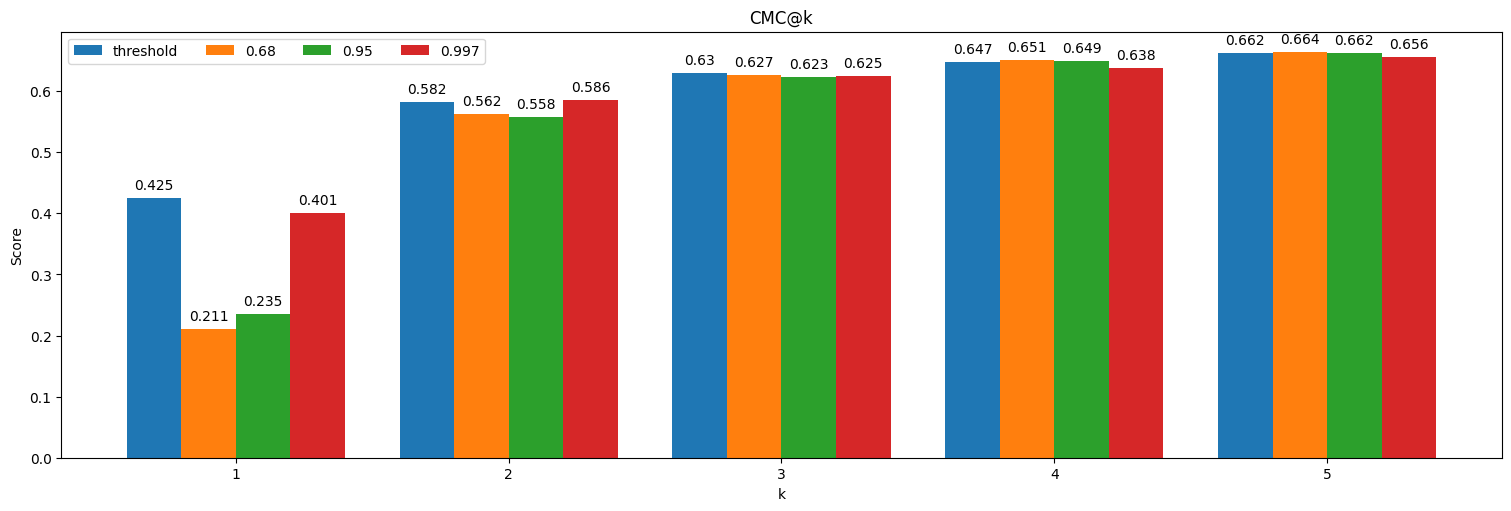

In [49]:
# CMC@k
plot_cmc_or_map(cmc_values, top_k, 'Score', 'CMC@k')

#### mAP@k

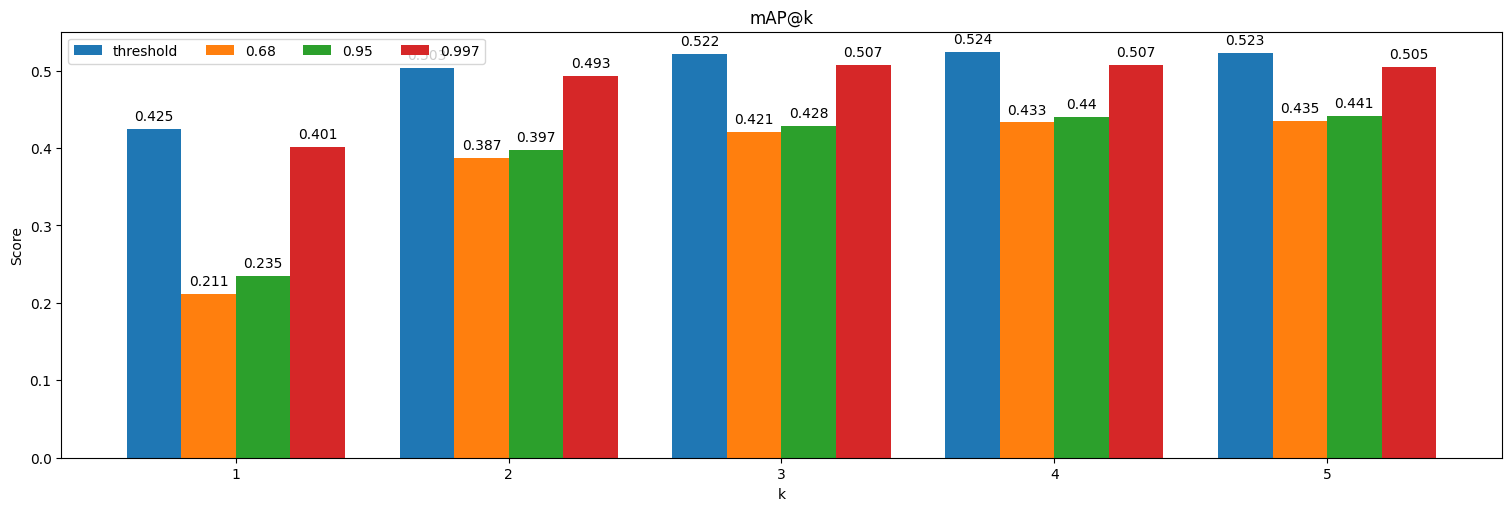

In [50]:
# mAP@k
plot_cmc_or_map(map_values, top_k, 'Score', 'mAP@k')

#### Accuracy

To compare the candidate's choice between 1-knn and n-knn. If n-knn, the lynx_id of the current image will be the one found most often among the neighbours.

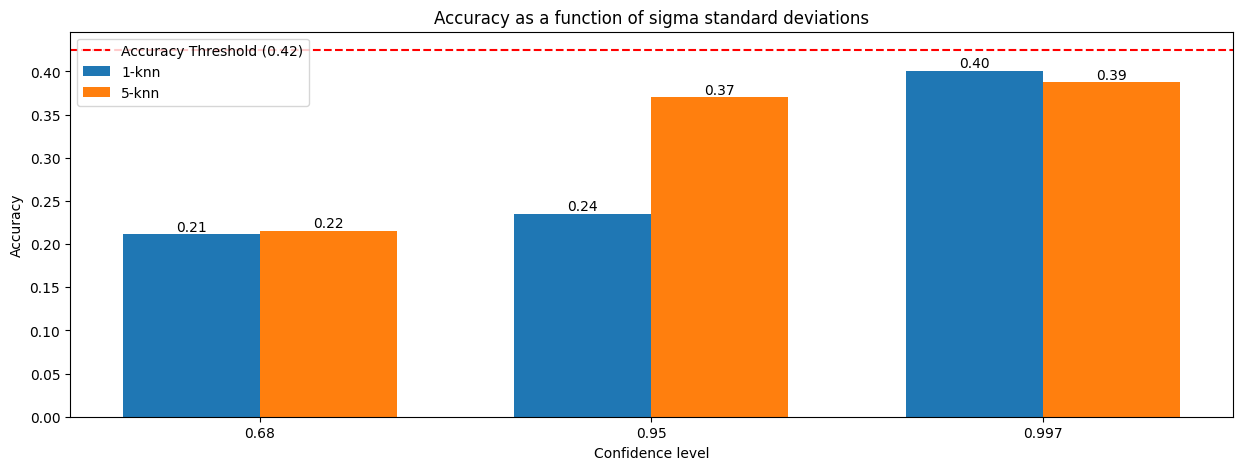

In [51]:
# Accuracy plot
accuracy_list_t = list(zip(*accuracy_list))

plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots()

width = 0.35

# Gaussian
bar1 = ax.bar(range(len(accuracy_list)), accuracy_list_t[0], width=width, label='1-knn')
bar2 = ax.bar([x + width for x in range(len(accuracy_list))], accuracy_list_t[1], width=width, label=f'{n_neighbors}-knn')

# Classic threshold
ax.axhline(y=accuracy_threshold, color='r', linestyle='--', label=f'Accuracy Threshold ({accuracy_threshold:.2f})')
ax.legend()

ax.set_xticks([x + width / 2 for x in range(len(accuracy_list))])
ax.set_xticklabels(confidence_levels)
ax.set_xlabel('Confidence level')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of sigma standard deviations')

ax.legend()

def add_text_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_text_labels(bar1)
add_text_labels(bar2)

plt.show()